In [5]:
import keras
from keras.layers import Input, Dense, Dropout, Flatten, MaxPooling2D, MaxPooling1D, Conv2D
from keras.models import Model, Sequential, model_from_yaml 
from keras import applications, optimizers
from vis.utils import utils
from keras import activations
from keras.models import Sequential, load_model
weights_path = 'VGG16_weights_aug.h5'

# load json and create model
yaml_file = open('fine_tune_VGG_model_aug.yaml', 'r')
loaded_model_yaml = yaml_file.read()
yaml_file.close()
model = model_from_yaml(loaded_model_yaml)
model.compile(loss='mean_squared_error', optimizer='adam')
model.load_weights(weights_path)

print("Loaded model from disk")
layer_dict = dict([(layer.name, layer) for layer in model.layers])
print('Layer dict', layer_dict)
print(model.summary())

Loaded model from disk
Layer dict {'input_1': <keras.engine.topology.InputLayer object at 0x121966048>, 'block1_conv1': <keras.layers.convolutional.Conv2D object at 0x125aa6860>, 'block1_conv2': <keras.layers.convolutional.Conv2D object at 0x1261fc0f0>, 'block1_pool': <keras.layers.pooling.MaxPooling2D object at 0x1261fc0b8>, 'block2_conv1': <keras.layers.convolutional.Conv2D object at 0x1261fce48>, 'block2_conv2': <keras.layers.convolutional.Conv2D object at 0x1261fc588>, 'block2_pool': <keras.layers.pooling.MaxPooling2D object at 0x1261fcc88>, 'block3_conv1': <keras.layers.convolutional.Conv2D object at 0x1261fcd30>, 'block3_conv2': <keras.layers.convolutional.Conv2D object at 0x1261fce10>, 'block3_conv3': <keras.layers.convolutional.Conv2D object at 0x10efa89b0>, 'block3_pool': <keras.layers.pooling.MaxPooling2D object at 0x1262512e8>, 'block4_conv1': <keras.layers.convolutional.Conv2D object at 0x126251208>, 'block4_conv2': <keras.layers.convolutional.Conv2D object at 0x1262512b0>,

In [6]:
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = utils.find_layer_idx(model, 'block5_conv1')

# Swap softmax with linear
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

/anaconda/envs/mypython3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/anaconda/envs/mypython3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


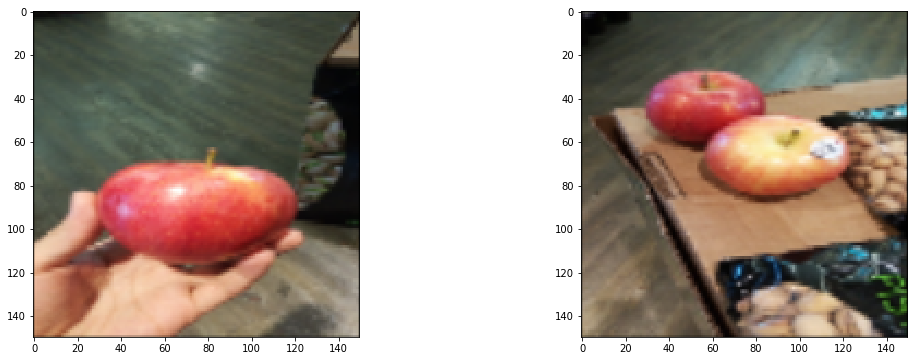

In [7]:
from vis.utils import utils
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (18, 6)

img1 = utils.load_img('data/train/apple_0.png', target_size=(150, 150))
img2 = utils.load_img('data/train/apple_1.png', target_size=(150, 150))

f, ax = plt.subplots(1, 2)
ax[0].imshow(img1)
ax[1].imshow(img2)

# Vanilla gradient

In [8]:
import numpy as np
import keras.backend as K

class SaliencyMask(object):
    """Base class for saliency masks. Alone, this class doesn't do anything."""
    def __init__(self, model, output_index=0):
        """Constructs a SaliencyMask.
        Args:
            model: the keras model used to make prediction
            output_index: the index of the node in the last layer to take derivative on
        """
        pass

    def get_mask(self, input_image):
        """Returns an unsmoothed mask.
        Args:
            input_image: input image with shape (H, W, 3).
        """
        pass

    def get_smoothed_mask(self, input_image, stdev_spread=.2, nsamples=50):
        """Returns a mask that is smoothed with the SmoothGrad method.
        Args:
            input_image: input image with shape (H, W, 3).
        """
        stdev = stdev_spread * (np.max(input_image) - np.min(input_image))

        total_gradients = np.zeros_like(input_image)
        for i in range(nsamples):
            noise = np.random.normal(0, stdev, input_image.shape)
            x_value_plus_noise = input_image + noise

            total_gradients = np.add(total_gradients,self.get_mask(x_value_plus_noise), out = total_gradients, casting="unsafe")

        return total_gradients / nsamples

class GradientSaliency(SaliencyMask):
    r"""A SaliencyMask class that computes saliency masks with a gradient."""

    def __init__(self, model, output_index=0):
        # Define the function to compute the gradient
        input_tensors = [model.input,        # placeholder for input image tensor
                         K.learning_phase(), # placeholder for mode (train or test) tense
                        ]
        gradients = model.optimizer.get_gradients(model.output[0][output_index], model.input)
        self.compute_gradients = K.function(inputs=input_tensors, outputs=gradients)

    def get_mask(self, input_image):
        """Returns a vanilla gradient mask.
        Args:
            input_image: input image with shape (H, W, 3).
        """
        
        # Execute the function to compute the gradient
        x_value = np.expand_dims(input_image, axis=0)
        gradients = self.compute_gradients([x_value, 0])[0][0]
        return gradients

In [9]:
model.summary()
vanilla = GradientSaliency(model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

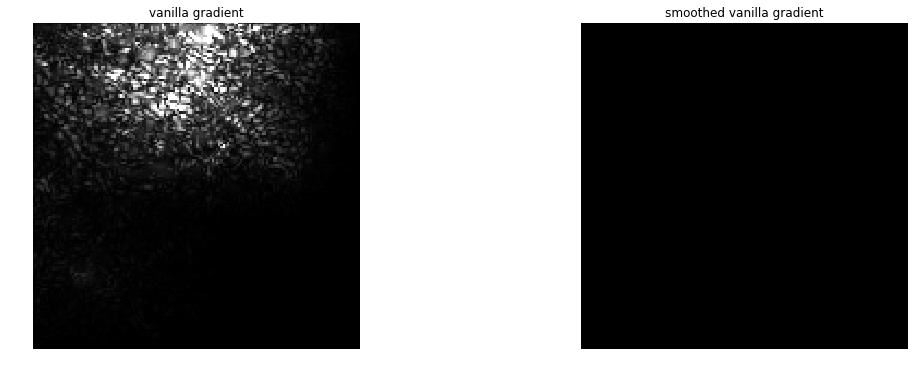

In [10]:
def show_image(image, grayscale = True, ax=None, title=''):
    if ax is None:
        plt.figure()
    plt.axis('off')
    
    if len(image.shape) == 2 or grayscale == True:
        if len(image.shape) == 3:
            image = np.sum(np.abs(image), axis=2)
            
        vmax = np.percentile(image, 99)
        vmin = np.min(image)

        plt.imshow(image, cmap=plt.cm.gray, vmin=vmin, vmax=vmax)
        plt.title(title)
    else:
        image = image + 127.5
        image = image.astype('uint8')
        
        plt.imshow(image)
        plt.title(title)

mask = vanilla.get_mask(img1)
show_image(mask, ax=plt.subplot('121'), title='vanilla gradient')

mask = vanilla.get_smoothed_mask(img1)
show_image(mask, ax=plt.subplot('122'), title='smoothed vanilla gradient')



# Integrated gradient

In [11]:
class IntegratedGradients(GradientSaliency):
    """A SaliencyMask class that implements the integrated gradients method.
    https://arxiv.org/abs/1703.01365
    """

    def GetMask(self, input_image, input_baseline=None, nsamples=100):
        """Returns a integrated gradients mask."""
        if input_baseline == None:
            input_baseline = np.zeros_like(input_image)
        print(input_image.shape)
        assert input_baseline.shape == input_image.shape

        input_diff = input_image - input_baseline

        total_gradients = np.zeros_like(input_image)

        for alpha in np.linspace(0, 1, nsamples):
            input_step = input_baseline + alpha * input_diff
            total_gradients = np.add(total_gradients,super(IntegratedGradients, self).get_mast(input_step),out = total_gradients, casting='unsafe')

        return total_gradients * input_diff

In [12]:
inter_grad = IntegratedGradients(model)

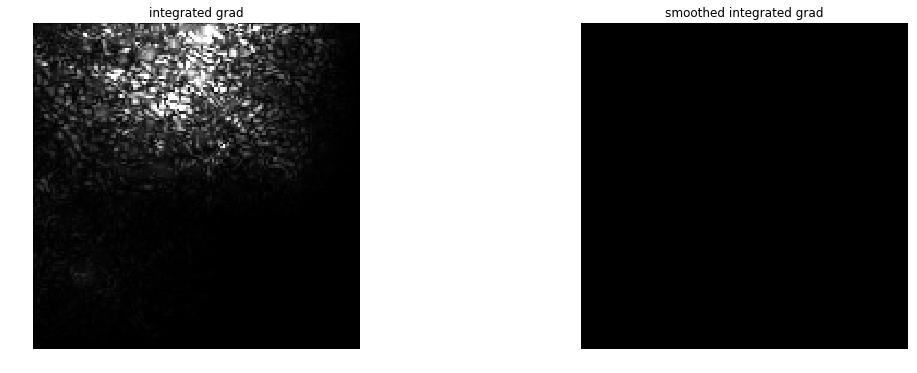

In [13]:
mask = inter_grad.get_mask(img1)
show_image(mask, ax=plt.subplot('121'), title='integrated grad')

mask = inter_grad.get_smoothed_mask(img1)
show_image(mask, ax=plt.subplot('122'), title='smoothed integrated grad')